## Import all library and settings

In [1]:
from utility import *
from settings import *
from model import EMA, WaveGradNN, SateLight
import logging
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.linalg import sqrtm
import numpy as np

MODEL_FILE_DIRC_SateLight = MODEL_FILE_DIRC + "/SateLight"
torch.manual_seed(3407)

In [2]:
device        = torch.device('cpu')
seperate      = "\n" + "-" * 100 + "\n"
logging.basicConfig(level=20, format =seperate + "     %(levelname)s : PID:%(process)d : %(asctime)s : %(message)s" + seperate )
configuration = {"batch_size":BATCH_SIZE, "max_count":MAX_COUNT, "learning_rate":LEARNING_RATE}

MODEL_FILE_DIRC_WaveGrad = MODEL_FILE_DIRC + "/WaveGrad"

## Theory behind image generation using diffusion model
### Diffusion Process

<img src="Image/diffusion.png" alt="Diffusion Process">

### Variable used
<img src="Image/variable.png" alt="Variable" width="500" height="500">

### Formula from: [Sources](https://nn.labml.ai/diffusion/stable_diffusion/sampler/ddpm.html)
* 這裏用著舊的，新的mean = 
<img src="Image/Generate_Signal.png" alt="Generate_Signal" width="500" height="500">
* Variance remain same

## Plot the loss graph

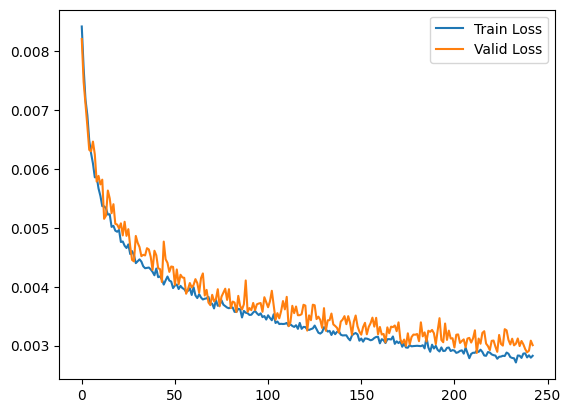

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(f'{MODEL_FILE_DIRC_WaveGrad}/Loss.csv')
df = df.iloc[5:, :] 
plt.plot(range(len(df["Train Loss"])), df["Train Loss"], label="Train Loss")
plt.plot(range(len(df["Valid Loss"])), df["Valid Loss"], label="Valid Loss")
plt.legend()
plt.savefig(f'{MODEL_FILE_DIRC_WaveGrad}/Loss.png', transparent=False, facecolor='white')

## Load the pretrained model

In [4]:
model     = WaveGradNN(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  
ema       = EMA(0.9) 
ema.register(model)

list_model = os.listdir(MODEL_FILE_DIRC_WaveGrad)
if len(list_model) > 0:    # Load the latest trained model
    if os.path.exists(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt"):
        state_dict_loaded    = torch.load(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt")
        model.load_state_dict(state_dict_loaded["model"])   
        ema.load_state_dict(state_dict_loaded["model"])
        
        print(f"The model has been loaded from the file 'Advanced_Diffusion_best.pt'")
    else:
        list_model.remove("Advanced_Diffusion_best.pt")
        num_list   = [int(model_dir[model_dir.rindex("_") +1: model_dir.rindex(".")]) for model_dir in list_model if model_dir.endswith(".pt")]
        num_max    = np.max(num_list)
        
        state_dict_loaded = torch.load(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_{num_max}.pt")
        model.load_state_dict(state_dict_loaded["model"])
        ema.load_state_dict(state_dict_loaded["model"])
        EPOCH_START = state_dict_loaded["epoch"]
        
        print(f"The model has been loaded from the file 'Advanced_Diffusion_{num_max}.pt'")

else:
    raise("No pretrained model exist in the folder 'Model' ")


The model has been loaded from the file 'Advanced_Diffusion_best.pt'


## Visualize the reconstructed output

### Pre-process the test dataset 

In [5]:
%%time
dataloaders, num_data = get_dataloader(list(range(1,41)), shuffle=True)
    

_, _, num_test_data = num_data
_, _, test_data         = dataloaders

The data from EEG_csv/eeg1.csv is loaded 
There is no spike in this eeg file
(252, 1280, 19)
EEG1 has 252 windows of data 


The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(43, 1280, 19)
EEG2 has 43 windows of data 


The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(88, 1280, 19)
EEG3 has 88 windows of data 


The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(245, 1280, 19)
EEG4 has 245 windows of data 


The data from EEG_csv/eeg5.csv is loaded 
There is no spike in this eeg file
(236, 1280, 19)
EEG5 has 236 windows of data 


The data from EEG_csv/eeg6.csv is loaded 
There is spike in this eeg file
Data before split : (481920, 19)
Data with spike   : (465280, 19)
Data without spike: (16640, 19)
Data after  split into window: (376, 1280, 19)
Labels: (376,)
Num spike: 13
EEG6 has 376 windows of data 


The data from EEG_csv/eeg7.csv is loaded 
There is no spike in this eeg file
(311, 1280, 19)
EEG7 h

### Recursively reconstructed difference signal (start from diffuse signal)

In [6]:
EVALUATE_DIR = "Evaluate_Diffusion_Model"
os.makedirs(EVALUATE_DIR, exist_ok=True)

for k, (original_signal, signal_DWT, label) in enumerate(test_data):
    if k == 5:
        break
    plt.ioff()
    diffuse_num_step = 500
    reconstruct_num_step = 500

    # rand_num = np.random.randint(0, original_signal.shape[0])
    rand_num = 0
    x_0      = original_signal[rand_num][None,:]
    x_0_DWT  = signal_DWT[rand_num][None,:]
    label        = label[rand_num].item()
    eps          = torch.randn_like(x_0)
    initial_x    = q_sample(x_0, alphas_prod_p_sqrt[diffuse_num_step-1], eps)

    x_seq   = p_sample_loop(model, 
                            x_0.shape, 
                            label   = torch.ones((1), dtype=torch.int64) if label==1 else torch.zeros((1), dtype=torch.int64),
                            n_steps = reconstruct_num_step, 
                            initial_x = initial_x,
                            x_DWT = x_0_DWT, 
                            device=torch.device("cpu"))  

    # Reverse the label
    x_seq1   = p_sample_loop(model, 
                            x_0.shape, 
                            label   = torch.zeros((1), dtype=torch.int64) if label==1 else torch.ones((1), dtype=torch.int64),
                            n_steps = reconstruct_num_step, 
                            initial_x = initial_x,
                            x_DWT = x_0_DWT, 
                            device=torch.device("cpu"))
    fig, axs = plt.subplots(len(AVE_CHANNELS_NAME), 1, figsize=(20, 50))

    sample = "Annotated" if label == 1 else "Un-annotated"
    seperate = 1
    for i, col in enumerate(AVE_CHANNELS_NAME):
        axs[i].set_title(col + sample)
        axs[i].plot(x_0[0][i], label=f"Original Signal")
        axs[i].plot(x_seq[0][0, i] + seperate, label=f"Noisy Signal_{diffuse_num_step}")
        axs[i].plot(x_seq[-1][0, i] - seperate, label=f"Reconstructed Signal_{reconstruct_num_step}")
        axs[i].plot(x_seq1[-1][0, i] - seperate*2,label=f"Reconstructed Signal_{reconstruct_num_step}_if_label_opposite")
        axs[i].legend()

    SAVE_PATH = f'{EVALUATE_DIR}/Signal_{k}.png'
    plt.savefig(SAVE_PATH, transparent=False, facecolor='white')

    plt.close('all')

In [6]:
EVALUATE_DIR = "Evaluate_Diffusion_Model_Plot_2"
os.makedirs(EVALUATE_DIR, exist_ok=True)

for k, (original_signal, signal_DWT, label) in enumerate(test_data):
    if k == 10:
        break
    plt.ioff()
    diffuse_num_step = 10
    reconstruct_num_step = 100

    # rand_num = np.random.randint(0, original_signal.shape[0])
    rand_num = 0
    x_0      = original_signal[rand_num][None,:]
    x_0_DWT  = signal_DWT[rand_num][None,:]
    label        = label[rand_num].item()
    eps          = torch.randn_like(x_0)
    initial_x    = q_sample(x_0, alphas_prod_p_sqrt[diffuse_num_step-1], eps)

    x_seq   = p_sample_loop(model, 
                            x_0.shape, 
                            label   = torch.ones((1), dtype=torch.int64) if label==1 else torch.zeros((1), dtype=torch.int64),
                            n_steps = reconstruct_num_step, 
                            initial_x = initial_x,
                            x_DWT = x_0_DWT, 
                            device=torch.device("cpu"))  

    # Reverse the label
    x_seq1   = p_sample_loop(model, 
                            x_0.shape, 
                            label   = torch.zeros((1), dtype=torch.int64) if label==1 else torch.ones((1), dtype=torch.int64),
                            n_steps = reconstruct_num_step, 
                            initial_x = initial_x,
                            x_DWT = x_0_DWT, 
                            device=torch.device("cpu"))
    
    
    # Plot the original signal
    sample = "Annotated" if label == 1 else "Un-annotated"
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    axs.set_title(sample)
    seperate=0.4
    for i, col in enumerate(AVE_CHANNELS_NAME):
        axs.plot(x_0[0, i, :] - x_0[0, i].mean() -seperate*i, color="k")
    for j in range(DURATION):
        axs.plot([j*NEW_FREQUENCY]*100, np.linspace(-seperate*len(AVE_CHANNELS_NAME),0,100), color="b")
    
    SAVE_PATH = f'{EVALUATE_DIR}/Original_Signal_{k}.png'
    plt.savefig(SAVE_PATH, transparent=False, facecolor='white')
    plt.close('all')
    
    # Plot the reconstructed signal
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    axs.set_title(sample)
    for i, col in enumerate(AVE_CHANNELS_NAME):
        axs.plot(x_seq[-1][0, i, :] - x_seq[-1][0, i].mean() - seperate*i, color="k")
    for j in range(DURATION):
        axs.plot([j*NEW_FREQUENCY]*100, np.linspace(-seperate*len(AVE_CHANNELS_NAME),0,100), color="b")
    
    SAVE_PATH = f'{EVALUATE_DIR}/Reconstructed_Signal_{k}.png'
    plt.savefig(SAVE_PATH, transparent=False, facecolor='white')
    plt.close('all')
    
    # Plot the reconstructed signal in opposite label
    sample = "Un-annotated" if label == 1 else "Annotated"
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    axs.set_title(sample)
    for i, col in enumerate(AVE_CHANNELS_NAME):
        axs.plot(x_seq1[-1][0, i, :] - x_seq1[-1][0, i].mean() - seperate*i, color="k")
    for j in range(DURATION):
        axs.plot([j*NEW_FREQUENCY]*100, np.linspace(-seperate*len(AVE_CHANNELS_NAME),0,100), color="b")
    
    SAVE_PATH = f'{EVALUATE_DIR}/Reconstructed_Signal_opposite_label_{k}.png'
    plt.savefig(SAVE_PATH, transparent=False, facecolor='white')
    plt.close('all')
    

## Perform Data Augmentation on train data with spike

### Generate Synthesized data and save it into a csv file

In [9]:
datasets, datasets_label, datasets_DWT = get_dataloader(list(range(1,41)), get_dataloader=False, shuffle=False)
    
train_dataset = datasets[0]
train_label   = datasets_label[0].type(torch.int64) 
train_DWT     = datasets_DWT[0]

The data from EEG_csv/eeg1.csv is loaded 
There is no spike in this eeg file
(252, 1280, 19)
EEG1 has 252 windows of data 


The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(43, 1280, 19)
EEG2 has 43 windows of data 


The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(88, 1280, 19)
EEG3 has 88 windows of data 


The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(245, 1280, 19)
EEG4 has 245 windows of data 


The data from EEG_csv/eeg5.csv is loaded 
There is no spike in this eeg file
(236, 1280, 19)
EEG5 has 236 windows of data 


The data from EEG_csv/eeg6.csv is loaded 
There is spike in this eeg file
Data before split : (481920, 19)
Data with spike   : (465280, 19)
Data without spike: (16640, 19)
Data after  split into window: (376, 1280, 19)
Labels: (376,)
Num spike: 13
EEG6 has 376 windows of data 


The data from EEG_csv/eeg7.csv is loaded 
There is no spike in this eeg file
(311, 1280, 19)
EEG7 h

In [10]:
%%time
num_step_used_list = [10, 30, 50, 100]

# Get the data with spike
x_0     = train_dataset[train_label==1]
x_0_DWT = train_DWT[train_label==1]
label   = train_label[train_label==1].type(torch.int64) 
eps     = torch.randn_like(x_0)
print(f"There is {len(x_0)} number of spike in training dataset")


synthesized_data = []
for i in range(10):
    print(f"For Iteration {i}")
    torch.manual_seed(i) 
    
    for num_step_used in num_step_used_list:
        diffuse_num_step      = num_step_used
        reconstruct_num_step  = num_step_used
        
        x_seq   = p_sample_loop(model, 
                                x_0.shape, 
                                label   = label,
                                n_steps = reconstruct_num_step, 
                                x_DWT   = x_0_DWT, 
                                device=torch.device("cpu"))  
        synthesized_data.append(x_seq[-1])
        print(f"> Done for step {num_step_used}")

There is 50 number of spike in training dataset
For Iteration 0
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 1
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 2
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 3
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 4
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 5
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 6
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 7
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 8
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
For Iteration 9
> Done for step 10
> Done for step 30
> Done for step 50
> Done for step 100
CPU times: total: 2h 4

In [11]:
synthesized_data_test = torch.cat(synthesized_data, axis=0)
print(synthesized_data_test.shape)

# Reshape the signal
bs, num_channel, num_signal = synthesized_data_test.shape
synthesized_data_test       = synthesized_data_test.permute(2,0,1).reshape(bs*num_signal,num_channel)

# Save into csv file
df = pd.DataFrame(synthesized_data_test, columns=AVE_CHANNELS_NAME)
df.to_csv(f"synthesized_data.csv", index=False)

torch.Size([2000, 19, 1280])


### Load the data and synthesized data

In [12]:
datasets, _, _ = get_dataloader(list(range(1,41)), get_dataloader=False, shuffle=False)
    
train_dataset       = datasets[0]

The data from EEG_csv/eeg1.csv is loaded 
There is no spike in this eeg file
(252, 1280, 19)
EEG1 has 252 windows of data 


The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(43, 1280, 19)
EEG2 has 43 windows of data 


The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(88, 1280, 19)
EEG3 has 88 windows of data 


The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(245, 1280, 19)
EEG4 has 245 windows of data 


The data from EEG_csv/eeg5.csv is loaded 
There is no spike in this eeg file
(236, 1280, 19)
EEG5 has 236 windows of data 


The data from EEG_csv/eeg6.csv is loaded 
There is spike in this eeg file
Data before split : (481920, 19)
Data with spike   : (465280, 19)
Data without spike: (16640, 19)
Data after  split into window: (376, 1280, 19)
Labels: (376,)
Num spike: 13
EEG6 has 376 windows of data 


The data from EEG_csv/eeg7.csv is loaded 
There is no spike in this eeg file
(311, 1280, 19)
EEG7 h

In [13]:
# Load the synthesized data from csv file
df                  = pd.read_csv("synthesized_data.csv")  # Shape=(num_data, num_channel)
synthesized_dataset = torch.tensor(df.values)
synthesized_dataset = synthesized_dataset.view(synthesized_dataset.shape[0]//(DURATION*NEW_FREQUENCY),-1 , len(AVE_CHANNELS_NAME)) # Shape=(bs, num_signal, num_channel)
synthesized_dataset = synthesized_dataset.permute(0,2,1)
synthesized_dataset = synthesized_dataset.type(torch.float32) 
synthesized_dataset.shape

torch.Size([2000, 19, 1280])

### Load the Satelight Model

In [14]:
model      = SateLight().to(device)
model.eval()
state_dict_loaded = torch.load(f"{MODEL_FILE_DIRC_SateLight}/SateLight_best.pt")
model.load_state_dict(state_dict_loaded["model"])

<All keys matched successfully>

### Get output from SateLight Models

In [15]:
def get_model_output(model, data, batch_size=BATCH_SIZE):
    dataloader = DataLoader(dataset = Dataset_Class1(data, torch.zeros((data.shape[0],), dtype=torch.int8)), 
                            batch_size = batch_size, shuffle = False, num_workers=1)
    
    list_output = []
    for curr_data, _ in dataloader:
        curr_data = curr_data.to(device)
        output    = model(curr_data)
        output    = torch.sigmoid(output.detach().cpu())
        
        list_output.append(output)
        
    list_output = torch.cat(list_output,axis=0)
    return list_output

In [16]:
output_original_data    = get_model_output(model, train_dataset)
output_synthesized_data = get_model_output(model, synthesized_dataset)

output_original_data    = output_original_data.numpy().flatten()
output_synthesized_data = output_synthesized_data.numpy().flatten()

In [17]:
def expand_dim_to_2(output):
    temp = np.zeros((output.shape[0],2))
    temp[:,0] = 1-output
    temp[:,1] = output
    return temp

output_original_data    = expand_dim_to_2(output_original_data) 
output_synthesized_data = expand_dim_to_2(output_synthesized_data)
print(output_synthesized_data.shape, output_original_data.shape)

(2000, 2) (6345, 2)


In [18]:
print("Number of label as no spike:",(output_synthesized_data[:, 0] > 0.5).sum())
print(output_synthesized_data[(output_synthesized_data[:, 0] < 0.5)])

Number of label as no spike: 1999
[[0.0138523 0.9861477]]


### Calculate the FID and IS

In [19]:
# Reference : https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
# Pass through a list of synthesized signals and classification model
def calculate_inception_score(act1, n_split=10, eps=1E-16):
        scores = []
        n_part = act1.shape[0] // n_split
        
        # enumerate splits of images/predictions
        for i in range(n_split):    
            # Retrieve the signals
            ix_start, ix_end = i * n_part, (i+1) * n_part # retrieve images
            p_yx = act1[ix_start:ix_end]                  # p(y|x)
            p_yx = p_yx.astype('float32')                 # Convert to float32
            p_y  = np.expand_dims(p_yx.mean(axis=0), 0)   # calculate p(y)
            
            # Calculate Inception score and append the result
            kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps)) # calculate KL divergence using log probabilities
            sum_kl_d = kl_d.sum(axis=1)                   # sum over classes
            avg_kl_d = np.mean(sum_kl_d)                  # average over images
            is_score = np.exp(avg_kl_d)                   # undo the log
            scores.append(is_score)                       # store
        is_avg, is_std = np.mean(scores), np.std(scores)  # average across images
        return is_avg, is_std
    

# calculate frechet inception distance
# Reference: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0) # calculate sum squared difference between means
    covmean = sqrtm(sigma1.dot(sigma2))  # calculate sqrt of product between cov
    
    if np.iscomplexobj(covmean): # check and correct imaginary numbers from sqrt
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean) # calculate score
    return fid

In [20]:
print("Inception Score of original    data:", calculate_inception_score(output_original_data))
print("Inception Score of synthesized data:", calculate_inception_score(output_synthesized_data))

Inception Score of original    data: (1.0400522, 0.056081645)
Inception Score of synthesized data: (1.0031211, 0.009363592)


In [21]:
print("FID Score:", calculate_fid(output_original_data, output_synthesized_data))

FID Score: 0.008961174504308613
